Processing Samples: 100%|██████████| 195/195 [00:09<00:00, 21.60sample/s]


Calculated thresholds:
 SNR < 12.10 dB
 Entropy > 4.71
 Energy < 6.13e+02


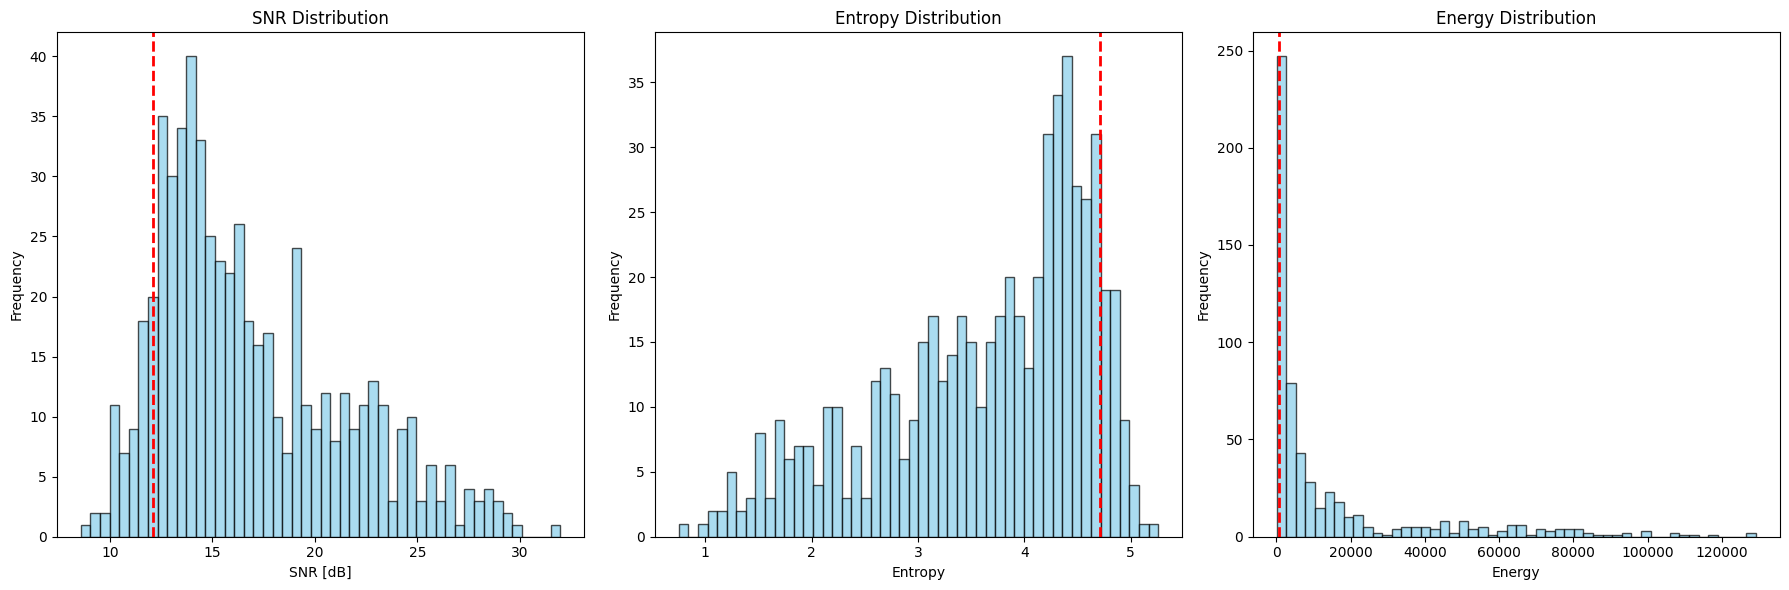

Total noise samples: 1
Noise Sample 1 (ID: 59037005_seg0): SNR = 10.42 dB, Entropy = 4.85, Energy = 1236.27


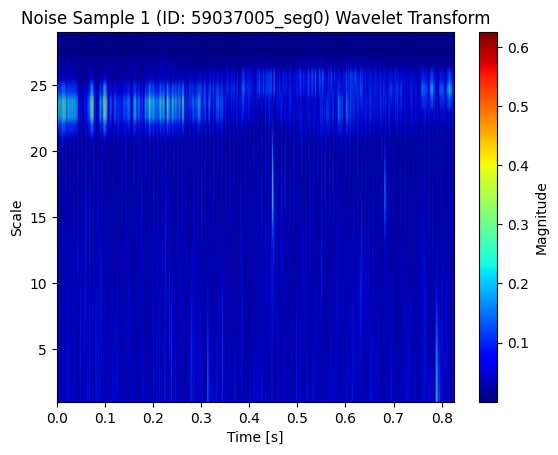

In [93]:
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from tqdm import tqdm  # 导入 tqdm
import pywt  # 导入小波变换模块

def normalize_signal(signal):
    """将信号归一化到 [0, 1] 范围"""
    min_val = np.min(signal)
    max_val = np.max(signal)
    return (signal - min_val) / (max_val - min_val)

def calculate_snr(signal):
    """计算归一化后的信号的 SNR"""
    signal = normalize_signal(signal)  # 对每个信号单独归一化
    power_signal = np.mean(signal ** 2)
    noise = signal - np.mean(signal)
    power_noise = np.mean(noise ** 2)
    if power_noise == 0:
        return float('inf')  # 避免除零错误
    return 10 * np.log10(power_signal / power_noise)

def calculate_entropy(signal):
    """计算信号的熵，信号先归一化到 [0, 1] 范围"""
    signal = normalize_signal(signal)  # 对每个信号单独归一化
    histogram, _ = np.histogram(signal, bins=50, density=True)
    histogram = histogram + 1e-10  # 避免 log(0)
    histogram = histogram / np.sum(histogram)  # 归一化概率密度，确保总和为1
    entropy = -np.sum(histogram * np.log2(histogram))
    return entropy

def calculate_wavelet_energy(signal, sr):
    """计算小波变换后的信号的能量"""
    signal = normalize_signal(signal)  # 对每个信号单独归一化
    scales = np.arange(1, 30)  # 设置适中的 scale 范围
    coefficients, _ = pywt.cwt(signal, scales, 'morl', 1.0 / sr)
    energy = np.sum(np.abs(coefficients) ** 2)  # 计算小波系数的能量
    return energy

# 加载数据
def load_data():
    data_whitebeaked = np.load(r"D:\Dataset\Temp_Results\Train_Test\whitebeaked_sounds.npy")
    data_atlanticspotted = np.load(r"D:\Dataset\Temp_Results\Train_Test\atlanticspotted_sounds.npy")
    data_whitesided = np.load(r"D:\Dataset\Temp_Results\Train_Test\whitesided_sounds.npy")
    
    sr_whitebeaked = np.load(r"D:\Dataset\Temp_Results\Train_Test\whitebeaked_sr.npy")
    sr_atlanticspotted = np.load(r"D:\Dataset\Temp_Results\Train_Test\atlanticspotted_sr.npy")
    sr_whitesided = np.load(r"D:\Dataset\Temp_Results\Train_Test\whitesided_sr.npy")
    
    ids_whitebeaked = np.load(r"D:\Dataset\Temp_Results\Train_Test\whitebeaked_ids.npy")
    ids_atlanticspotted = np.load(r"D:\Dataset\Temp_Results\Train_Test\atlanticspotted_ids.npy")
    ids_whitesided = np.load(r"D:\Dataset\Temp_Results\Train_Test\whitesided_ids.npy")
    
    return [(data_whitebeaked, sr_whitebeaked, ids_whitebeaked),
            (data_atlanticspotted, sr_atlanticspotted, ids_atlanticspotted),
            (data_whitesided, sr_whitesided, ids_whitesided)]

def plot_wavelet_transform(signal, sr, title):
    scales = np.arange(1, 30)  # 设置适中的 scale 范围
    coefficients, frequencies = pywt.cwt(signal, scales, 'morl', 1.0 / sr)
    
    plt.imshow(np.abs(coefficients), aspect='auto', extent=[0, len(signal)/sr, scales.min(), scales.max()], cmap='jet')
    plt.colorbar(label='Magnitude')
    plt.ylabel('Scale')
    plt.xlabel('Time [s]')
    plt.title(title)
    plt.show()

def plot_statistical_distributions(snr_values, entropy_values, energy_values, snr_threshold, entropy_threshold, energy_threshold):
    """绘制特性分布并标出阈值"""
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # 绘制 SNR 分布
    axs[0].hist(snr_values, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axs[0].axvline(snr_threshold, color='red', linestyle='dashed', linewidth=2)
    axs[0].set_title('SNR Distribution')
    axs[0].set_xlabel('SNR [dB]')
    axs[0].set_ylabel('Frequency')
    
    # 绘制 熵 分布
    axs[1].hist(entropy_values, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axs[1].axvline(entropy_threshold, color='red', linestyle='dashed', linewidth=2)
    axs[1].set_title('Entropy Distribution')
    axs[1].set_xlabel('Entropy')
    axs[1].set_ylabel('Frequency')
    
    # 绘制 能量 分布
    axs[2].hist(energy_values, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axs[2].axvline(energy_threshold, color='red', linestyle='dashed', linewidth=2)
    axs[2].set_title('Energy Distribution')
    axs[2].set_xlabel('Energy')
    axs[2].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def main():
    datasets = load_data()
    all_samples = []
    snr_values = []
    entropy_values = []
    energy_values = []
    noise_samples = []  # 保存噪声样本
    
    # 使用 tqdm 显示进度条
    for data, sr, ids in datasets:
        for i in tqdm(range(len(data)), desc="Processing Samples", unit="sample"):  # 添加进度条
            snr = calculate_snr(data[i])
            entropy = calculate_entropy(data[i])
            energy = calculate_wavelet_energy(data[i], sr[i])  # 使用小波变换后的能量
            
            # 收集 SNR、熵、能量值
            snr_values.append(snr)
            entropy_values.append(entropy)
            energy_values.append(energy)
            
            # 判断是否为噪声
            high_entropy = entropy > np.percentile(entropy_values, 90)
            low_snr = snr < np.percentile(snr_values, 10)
            low_energy = energy < np.percentile(energy_values, 10)
            
            is_noise = high_entropy and low_snr and low_energy  # 新的噪声判定条件
            
            # 保存噪声样本以及对应的ID
            if is_noise:
                noise_samples.append((ids[i], data[i], sr[i], snr, entropy, energy))  # 保存噪声样本
            
            all_samples.append((ids[i], data[i], sr[i], snr, entropy, energy))
    
    # 基于统计特性计算阈值
    snr_threshold = np.percentile(snr_values, 10)  # 取 SNR 的 10 百分位
    entropy_threshold = np.percentile(entropy_values, 90)  # 取熵的 90 百分位
    energy_threshold = np.percentile(energy_values, 10)  # 取能量的 10 百分位

    print(f"Calculated thresholds:\n SNR < {snr_threshold:.2f} dB\n Entropy > {entropy_threshold:.2f}\n Energy < {energy_threshold:.2e}")
    
    # 绘制统计分布
    plot_statistical_distributions(snr_values, entropy_values, energy_values, snr_threshold, entropy_threshold, energy_threshold)
    
    noise_count = len(noise_samples)
    print(f"Total noise samples: {noise_count}")
    
    # 随机选取 10 个噪声样本
    random_noise_samples = random.sample(noise_samples, 10) if noise_count >= 10 else noise_samples
    
    for i, (sample_id, signal, sr, snr, entropy, energy) in enumerate(random_noise_samples):
        print(f"Noise Sample {i+1} (ID: {sample_id}): SNR = {snr:.2f} dB, Entropy = {entropy:.2f}, Energy = {energy:.2f}")
        
        plot_wavelet_transform(signal, sr, f"Noise Sample {i+1} (ID: {sample_id}) Wavelet Transform")
        display(Audio(signal, rate=sr))

main()
